In [1]:
from pathlib import Path
import numpy as np

from sklearn.model_selection import train_test_split

from keras.preprocessing.image import img_to_array, load_img
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [2]:
def show_random_images(ds, labels, h=5, w=5):
    idxs = np.random.randint(0, ds.shape[0] - 1, size=w * h).tolist()
    
    plt.figure(figsize=(w, h))
    for i, idx in enumerate(idxs):
        plt.subplot(h, w, i + 1)
        image = ds[idx]
        plt.imshow(image)
        plt.title(LABELS[np.argmax(labels[idx])])
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()

In [3]:
def predict_random_images(ds, model, h=5, w=5):
    idxs = np.random.randint(0, ds.shape[0] - 1, size=w * h).tolist()
    subset = ds[idxs]
    labels = model.predict_classes(subset, verbose=0)
    
    plt.figure(figsize=(w, h))    
    for i, label in enumerate(labels):
        plt.subplot(h, w, i + 1)
        image = subset[i].reshape(32, 32, 3)
#         image = image.astype(np.uint8)
        plt.imshow(image)
        plt.title(LABELS[label])
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()

In [4]:
def predict_image(img_file, model=None):
    plt.figure(figsize=(5, 5))
    img = load_img(img_file)  
    plt.imshow(img)    
    
    img = img.resize(size=(image_width, image_height))
    x = img_to_array(img)
    x = (x - np.min(x)) / (np.max(x) - np.min(x))    
    x = x.reshape(1, image_height, image_width, n_channels)    
    
    class_probs = model.predict(x)
    label = LABELS[np.argmax(class_probs)]
    conf = 100 * np.max(class_probs)
    
    plt.title('%s(%0.2f%%)' % (label, conf))
    plt.xticks([])
    plt.yticks([])

In [5]:
def plot_history(history, params=['loss', 'acc']):
    for param in params:
        plt.plot(history.history[param], label='train')
        if 'val_%s' % param in history.history.keys():
            plt.plot(history.history['val_%s' % param], label='test')
        plt.xlabel('epoch')
        plt.ylabel(param)
        plt.title(param.capitalize())
        plt.legend()
        plt.show()

In [6]:
IMG_DIR = 'images'
LABELS = ['circle', 'square', 'triangle']

In [7]:
n_channels = 3
image_height, image_width = 32, 32
n_images = 30000

In [8]:
x_train = np.ndarray(shape=(n_images, image_height, image_width, n_channels), dtype=np.float32)
y_train = []

In [9]:
idx = 0
for i, label in enumerate(LABELS):
    for f in (Path(IMG_DIR) / label).iterdir():
        x = img_to_array(load_img(f))
        x = x.reshape(image_height, image_width, n_channels)
        x = (x - np.min(x)) / (np.max(x) - np.min(x)) 
        x_train[idx] = x
        y_train.append(i)
        idx += 1

In [10]:
print(x_train.shape)
print(len(y_train))

(30000, 32, 32, 3)
30000


In [11]:
x_train;

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2)
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [13]:
print(x_train.shape)
print(len(y_train))

(24000, 32, 32, 3)
24000


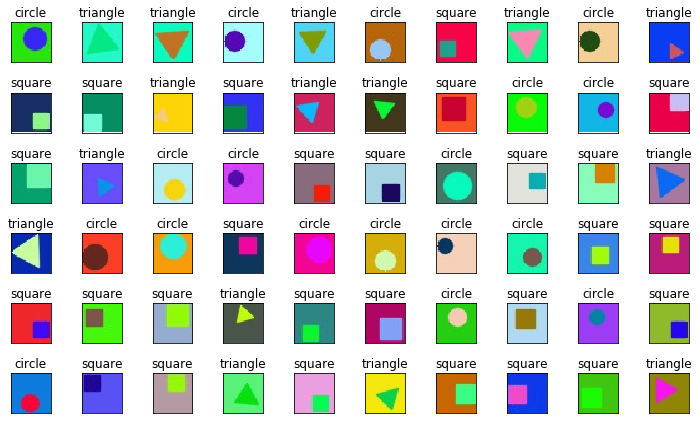

In [14]:
show_random_images(x_train, y_train, h=6, w=10)

In [15]:
def build_model():
    model = Sequential()
    
    model.add(Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same',
                     input_shape=(image_height, image_width, n_channels),
                     data_format='channels_last'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    
    model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPool2D(pool_size=(2, 2)))

    
    model.add(Flatten())
    model.add(Dense(units=32, activation='relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(units=3, activation='softmax'))
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [16]:
model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 8)         224       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 16)        1168      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 16)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 32)          4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
__________

In [17]:
history = model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

Train on 24000 samples, validate on 6000 samples
Epoch 1/5
24000/24000 [==============================] - 20s 847us/step - loss: 0.7994 - acc: 0.6024 - val_loss: 0.3034 - val_acc: 0.8935
Epoch 2/5
24000/24000 [==============================] - 22s 908us/step - loss: 0.2160 - acc: 0.9165 - val_loss: 0.1128 - val_acc: 0.9588
Epoch 3/5
24000/24000 [==============================] - 18s 734us/step - loss: 0.1193 - acc: 0.9544 - val_loss: 0.0734 - val_acc: 0.9768
Epoch 4/5
24000/24000 [==============================] - 20s 840us/step - loss: 0.0785 - acc: 0.9706 - val_loss: 0.0430 - val_acc: 0.9843
Epoch 5/5
24000/24000 [==============================] - 19s 803us/step - loss: 0.0661 - acc: 0.9762 - val_loss: 0.0403 - val_acc: 0.9860


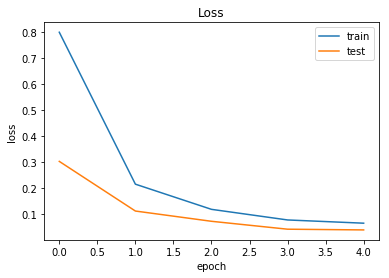

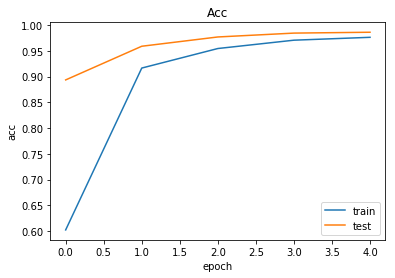

In [18]:
plot_history(history)

In [19]:
# Better with min-max scaling
acc = 100 * model.evaluate(x_test, y_test, verbose=0)[1]
print('Model val acc: %0.2f%%' % acc)

Model val acc: 98.60%


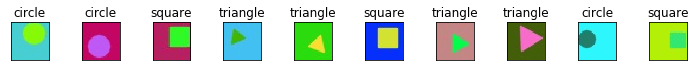

In [20]:
predict_random_images(x_test, model, 1, 10)

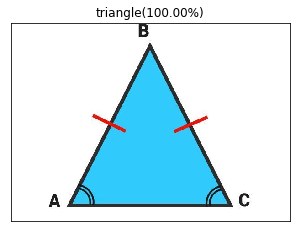

In [29]:
predict_image('tri__.jpg', model)